In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 1: Load dataset
df = pd.read_excel('Online Retail.xlsx')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# Reduce dataset size to 25,000 rows randomly
df = df.sample(n=25000, random_state=0).reset_index(drop=True)

# Step 2: Data Preprocessing
# Drop rows with missing values in 'CustomerID' and 'Description'
df = df.dropna(subset=['CustomerID', 'Description'])

# Create a new feature "TotalPrice" (Quantity * UnitPrice)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Group data by 'CustomerID' to create customer-level features
customer_df = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',          # Number of transactions
    'Quantity': 'sum',               # Total quantity purchased
    'TotalPrice': 'sum',             # Total amount spent
}).rename(columns={'InvoiceNo': 'NumTransactions', 'Quantity': 'TotalQuantity', 'TotalPrice': 'TotalSpent'})

# Step 3: Feature Scaling
scaler = StandardScaler()
df_scaled = scaler.fit_transform(customer_df)

# Step 4: Dimensionality Reduction with PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(df_scaled)

# Prepare the clustering algorithms
kmeans_inertia = []
kmeans_silhouette_scores = []
agg_silhouette_scores = []


## K-MEANS

In [5]:
# KMeans clustering 
kmeans_labels = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=10, random_state=42)
    kmeans.fit(df_scaled)
    kmeans_labels.append(kmeans.labels_)
    kmeans_inertia.append(kmeans.inertia_)
    kmeans_silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))



## Agglomerative Clustering

In [6]:
# Agglomerative clustering 
agglo_labels = []
agglo_silhouette_scores = []
for n_clusters in range(2, 11):
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agglo.fit_predict(df_scaled)
    agglo_labels.append(labels)
    agglo_silhouette_scores.append(silhouette_score(df_scaled, labels))


## DBSCAN

In [7]:
# DBSCAN clustering 
dbscan = DBSCAN(eps=1.7)
dbscan_labels = dbscan.fit_predict(df_scaled)

## KESIMPULAN

In [8]:
# Step 5: Visualization
# Apply PCA for 2D visualization
pca_features = pca.fit_transform(df_scaled)
customer_df['PCA1'] = pca_features[:, 0]
customer_df['PCA2'] = pca_features[:, 1]

In [9]:
# Step 6: Model Evaluation Metrics
# Assuming the final model used for evaluation is KMeans with k=7, Agglomerative with n_clusters=3, and DBSCAN
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(df_scaled)
kmeans_labels_final = kmeans.labels_

agglo = AgglomerativeClustering(n_clusters=3)
agglo_labels_final = agglo.fit_predict(df_scaled)

dbscan_labels_final = dbscan.labels_

# KMeans Evaluation
kmeans_silhouette = silhouette_score(df_scaled, kmeans_labels_final)
kmeans_davies_bouldin = davies_bouldin_score(df_scaled, kmeans_labels_final)
kmeans_calinski_harabasz = calinski_harabasz_score(df_scaled, kmeans_labels_final)

# Agglomerative Clustering Evaluation
agglo_silhouette = silhouette_score(df_scaled, agglo_labels_final)
agglo_davies_bouldin = davies_bouldin_score(df_scaled, agglo_labels_final)
agglo_calinski_harabasz = calinski_harabasz_score(df_scaled, agglo_labels_final)

# DBSCAN Evaluation (Only compute if more than 1 cluster)
if len(set(dbscan_labels_final)) > 1:
    dbscan_silhouette = silhouette_score(df_scaled, dbscan_labels_final)
    dbscan_davies_bouldin = davies_bouldin_score(df_scaled, dbscan_labels_final)
    dbscan_calinski_harabasz = calinski_harabasz_score(df_scaled, dbscan_labels_final)
else:
    dbscan_silhouette = np.nan
    dbscan_davies_bouldin = np.nan
    dbscan_calinski_harabasz = np.nan

# Displaying results
print("Clustering Model Evaluation Metrics:")

# KMeans
print("\nK-Means: (k=7)")
print(f" - Silhouette Score: {kmeans_silhouette:.2f}")
print(f" - Davies-Bouldin Index: {kmeans_davies_bouldin:.2f}")
print(f" - Calinski-Harabasz Index: {kmeans_calinski_harabasz:.2f}")

# Agglomerative Clustering
print("\nAgglomerative Clustering: (n_clusters=3)")
print(f" - Silhouette Score: {agglo_silhouette:.2f}")
print(f" - Davies-Bouldin Index: {agglo_davies_bouldin:.2f}")
print(f" - Calinski-Harabasz Index: {agglo_calinski_harabasz:.2f}")

# DBSCAN
print("\nDBSCAN: (eps=1.7)")
print(f" - Silhouette Score: {dbscan_silhouette if not np.isnan(dbscan_silhouette) else 'N/A'}")
print(f" - Davies-Bouldin Index: {dbscan_davies_bouldin if not np.isnan(dbscan_davies_bouldin) else 'N/A'}")
print(f" - Calinski-Harabasz Index: {dbscan_calinski_harabasz if not np.isnan(dbscan_calinski_harabasz) else 'N/A'}")

# Step 7: Summary of Best Model
print("\nSummary:")

# Handle NaN values in the metrics
metrics = {
    'Silhouette': [kmeans_silhouette, agglo_silhouette, dbscan_silhouette],
    'Davies-Bouldin': [kmeans_davies_bouldin, agglo_davies_bouldin, dbscan_davies_bouldin],
    'Calinski-Harabasz': [kmeans_calinski_harabasz, agglo_calinski_harabasz, dbscan_calinski_harabasz]
}

# Filter out NaN values before finding the best model for each metric
best_silhouette = max((x for x in metrics['Silhouette'] if not np.isnan(x)), default=np.nan)
best_davies_bouldin = min((x for x in metrics['Davies-Bouldin'] if not np.isnan(x)), default=np.nan)
best_calinski_harabasz = max((x for x in metrics['Calinski-Harabasz'] if not np.isnan(x)), default=np.nan)

# Determine best model based on each metric
best_silhouette_model = ["K-Means", "Agglomerative Clustering", "DBSCAN"][metrics['Silhouette'].index(best_silhouette) if not np.isnan(best_silhouette) else -1]
best_davies_bouldin_model = ["K-Means", "Agglomerative Clustering", "DBSCAN"][metrics['Davies-Bouldin'].index(best_davies_bouldin) if not np.isnan(best_davies_bouldin) else -1]
best_calinski_harabasz_model = ["K-Means", "Agglomerative Clustering", "DBSCAN"][metrics['Calinski-Harabasz'].index(best_calinski_harabasz) if not np.isnan(best_calinski_harabasz) else -1]

# Print summary of the best models
print(f"Best Model Based on Silhouette Score: {best_silhouette_model}")
print(f"Best Model Based on Davies-Bouldin Index: {best_davies_bouldin_model}")
print(f"Best Model Based on Calinski-Harabasz Index: {best_calinski_harabasz_model}")


Clustering Model Evaluation Metrics:

K-Means: (k=7)
 - Silhouette Score: 0.69
 - Davies-Bouldin Index: 0.66
 - Calinski-Harabasz Index: 2902.24

Agglomerative Clustering: (n_clusters=3)
 - Silhouette Score: 0.95
 - Davies-Bouldin Index: 0.79
 - Calinski-Harabasz Index: 2313.62

DBSCAN: (eps=1.7)
 - Silhouette Score: 0.9482541042637593
 - Davies-Bouldin Index: 0.8416889259831413
 - Calinski-Harabasz Index: 2288.2939007545497

Summary:
Best Model Based on Silhouette Score: Agglomerative Clustering
Best Model Based on Davies-Bouldin Index: K-Means
Best Model Based on Calinski-Harabasz Index: K-Means


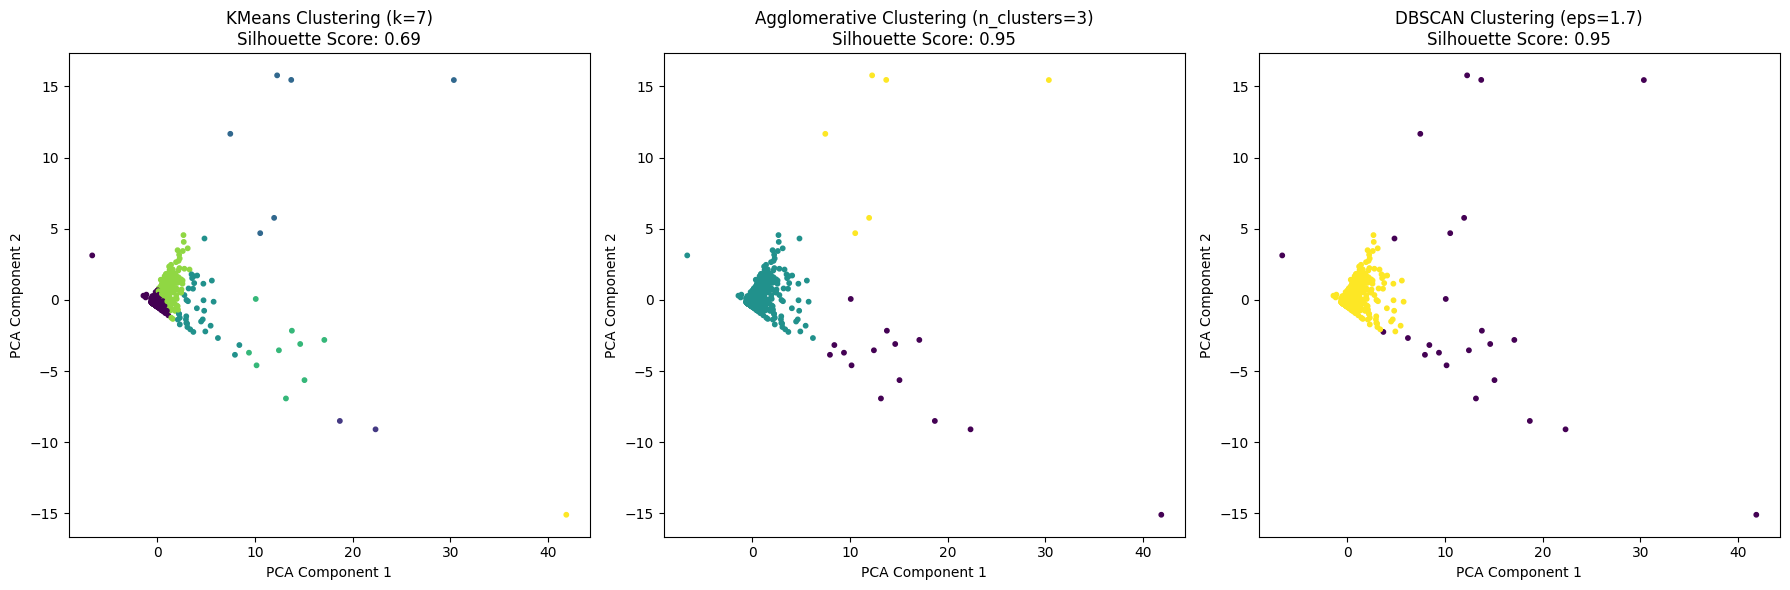

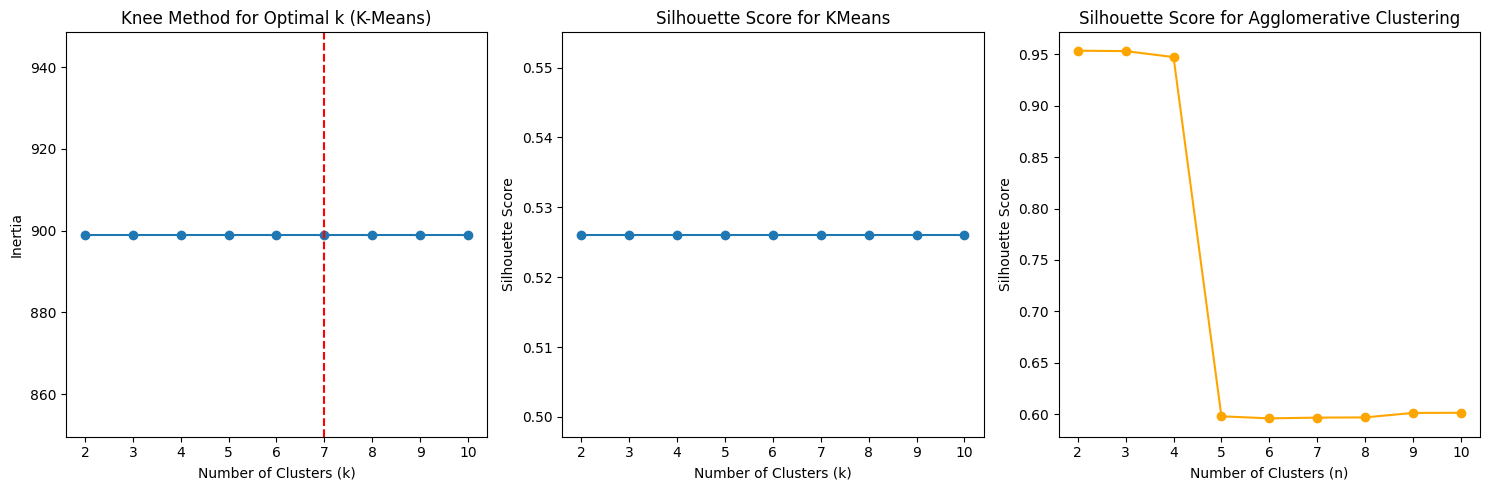

In [10]:
# Step 8: Plot Clustering Results and Metrics
plt.figure(figsize=(18, 6))

# Plot KMeans clustering
plt.subplot(1, 3, 1)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans_labels_final, cmap='viridis', s=10)
plt.title(f'KMeans Clustering (k=7)\nSilhouette Score: {kmeans_silhouette:.2f}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Plot Agglomerative clustering
plt.subplot(1, 3, 2)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=agglo_labels_final, cmap='viridis', s=10)
plt.title(f'Agglomerative Clustering (n_clusters=3)\nSilhouette Score: {agglo_silhouette:.2f}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Plot DBSCAN clustering
plt.subplot(1, 3, 3)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=dbscan_labels_final, cmap='viridis', s=10)
plt.title(f'DBSCAN Clustering (eps=1.7)\nSilhouette Score: {dbscan_silhouette:.2f}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

# Step 9: Plot Knee and Silhouette Scores
plt.figure(figsize=(15, 5))

# Knee (Inertia vs. Number of Clusters)
plt.subplot(1, 3, 1)
plt.plot(range(2, 11), kmeans_inertia, marker='o')
plt.axvline(7, color='red', linestyle='--')  # Example of the "knee" point for k=7
plt.title('Knee Method for Optimal k (K-Means)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# Silhouette Scores for KMeans
plt.subplot(1, 3, 2)
plt.plot(range(2, 11), kmeans_silhouette_scores, marker='o')
plt.title('Silhouette Score for KMeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

# Silhouette Scores for Agglomerative Clustering
plt.subplot(1, 3, 3)
plt.plot(range(2, 11), agglo_silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score for Agglomerative Clustering')
plt.xlabel('Number of Clusters (n)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()